# moscot-lineage basics

This example is adapted from [Vayer et al. 2019](https://pythonot.github.io/auto_examples/gromov/plot_fgw.html#sphx-glr-auto-examples-plot-fgw-py) illustrating `moscot-lineage` FGW computation for 1D measures (in comparison to `OT` and `GW`)

## Import packages

In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

# from moscot import FusedGW
from ott.geometry.geometry import Geometry
from jax import numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ot
from ot.gromov import fused_gromov_wasserstein, entropic_gromov_wasserstein, gromov_wasserstein


In [3]:
import os
import sys
# local git import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from moscot import FusedGW, GW, Regularized

## Set plotting parameters

In [4]:
sns.set_style("whitegrid", {'xtick.direction': 'out', 'xtick.major.size': 6.0, 'xtick.minor.size': 3.0,
    'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6.0, 'ytick.minor.size': 3.0, 
                           'font': ['DejaVu Sans'], 'font.scale': 1.6})

## Simulate data

In [7]:
n = 20  # number of points in the first distribution
n2 = 30  # number of points in the second distribution
sig = 1  # std of first distribution
sig2 = 0.1  # std of second distribution

np.random.seed(0)

# source data (s)
phi = np.arange(n)[:, None]
xs = phi + sig * np.random.randn(n, 1)
ys = np.vstack((np.ones((n // 2, 1)), 0 * np.ones((n // 2, 1)))) + sig2 * np.random.randn(n, 1)

# target data (t)
phi2 = np.arange(n2)[:, None]
xt = phi2 + sig * np.random.randn(n2, 1)
yt = np.vstack((np.ones((n2 // 2, 1)), 0 * np.ones((n2 // 2, 1)))) + sig2 * np.random.randn(n2, 1)
yt = yt[::-1, :]

p = ot.unif(n)
q = ot.unif(n2)

## Visualize the data
We have a structure space, given by $x$ and $y$, which is specific to each space. Also, we have a feature space which is shared. The featrue space is shown on the $y$-axis, and the color is just the $y$-value.

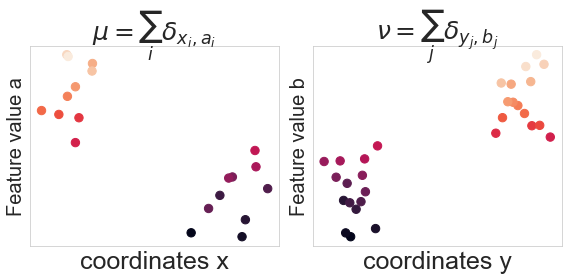

In [8]:
rows = 1
cols = 2
size  = 4

fig, axs = plt.subplots(rows, cols, figsize=(cols*(size),rows*(size)))



axs[0].scatter(ys, xs, c=phi, s=70)
axs[0].set_ylabel('Feature value a', fontsize=20)
axs[0].set_xlabel('coordinates x', fontsize=25)
axs[0].set_title(r'$\mu=\sum_i \delta_{x_i,a_i}$', fontsize=25, y=1)
axs[0].set_xticks(())
axs[0].set_yticks(())

axs[1].scatter(yt, xt, c=phi2, s=70)
axs[1].set_xlabel('coordinates y', fontsize=25)
axs[1].set_ylabel('Feature value b', fontsize=20)
axs[1].set_title(r'$\nu=\sum_j \delta_{y_j,b_j}$', fontsize=25, y=1)
axs[1].set_yticks(())
axs[1].set_xticks(())

plt.tight_layout()
plt.show()


# Compute transportation maps
## Define cost matrices

In [25]:
alpha = 0.5
alpha_un = 0.2
epsilon = 5e+1

# build structure matrices on the x-coordinates
C1 = ot.dist(xs)
C2 = ot.dist(xt)

# build feature matrix on y-coordinates (shared between both spaces. )
M = ot.dist(ys, yt)

# uniform marginals
w1 = ot.unif(C1.shape[0])
w2 = ot.unif(C2.shape[0])


Got = ot.emd([], [], M)

## Plot matrices

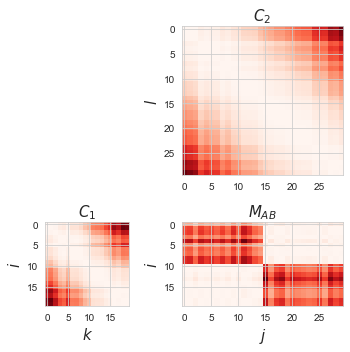

In [10]:
cmap = 'Reds'
plt.close(10)
plt.figure(10, (5, 5))
fs = 15
l_x = [0, 5, 10, 15]
l_y = [0, 5, 10, 15, 20, 25]
gs = plt.GridSpec(5, 5)

ax1 = plt.subplot(gs[3:, :2])

plt.imshow(C1, cmap=cmap, interpolation='nearest')
plt.title("$C_1$", fontsize=fs)
plt.xlabel("$k$", fontsize=fs)
plt.ylabel("$i$", fontsize=fs)
plt.xticks(l_x)
plt.yticks(l_x)

ax2 = plt.subplot(gs[:3, 2:])

plt.imshow(C2, cmap=cmap, interpolation='nearest')
plt.title("$C_2$", fontsize=fs)
plt.ylabel("$l$", fontsize=fs)
#plt.ylabel("$l$",fontsize=fs)
plt.xticks(())
plt.yticks(l_y)
ax2.set_aspect('auto')

ax3 = plt.subplot(gs[3:, 2:], sharex=ax2, sharey=ax1)
plt.imshow(M, cmap=cmap, interpolation='nearest')
plt.yticks(l_x)
plt.xticks(l_y)
plt.ylabel("$i$", fontsize=fs)
plt.title("$M_{AB}$", fontsize=fs)
plt.xlabel("$j$", fontsize=fs)
plt.tight_layout()
ax3.set_aspect('auto')
plt.show()

## `moscot-lineage`

### FGW

In [26]:
C1_g = Geometry(cost_matrix=jnp.asarray(C1))
C2_g = Geometry(cost_matrix=jnp.asarray(C2))
M_g = Geometry(cost_matrix=jnp.asarray(M))

fgwot_bal = FusedGW(alpha=alpha, epsilon=epsilon)
fgwot_bal.fit(C1_g, C2_g, M_g)



fgwot_unbal = FusedGW(alpha=alpha_un, epsilon=epsilon)
fgwot_unbal.fit(C1_g, C2_g, M_g)

It.  |Loss        |Rel. loss   |Abs. loss   |tau         |converged   |eps         
-----------------------------------------------------------------------------------
    1|4.341899e+04|1.000000e+00|4.341899e+04|1.000000e+00|           1|5.000000e+01
    2|3.768536e+04|1.521448e-01|5.733631e+03|1.000000e+00|           1|5.000000e+01
    3|2.201577e+04|7.117440e-01|1.566959e+04|1.000000e+00|           1|5.000000e+01
    4|2.198620e+04|1.344937e-03|2.957006e+01|1.000000e+00|           1|5.000000e+01
    5|2.198625e+04|2.343655e-06|5.152819e-02|1.000000e+00|           1|5.000000e+01
    6|2.198625e+04|1.104659e-08|2.428730e-04|1.000000e+00|           1|5.000000e+01
It.  |Loss        |Rel. loss   |Abs. loss   |tau         |converged   |eps         
-----------------------------------------------------------------------------------
    1|1.741295e+04|1.000000e+00|1.741295e+04|1.000000e+00|           1|5.000000e+01
    2|1.534577e+04|1.347068e-01|2.067179e+03|1.000000e+00|           1|5.000

### GW

In [12]:
gw = GW(epsilon=epsilon)
gw.fit(C1_g, C2_g, p, q)

### OT

In [20]:
regot = Regularized(epsilon=1e-3)
regot.fit(M_g, p, q)

## Plot

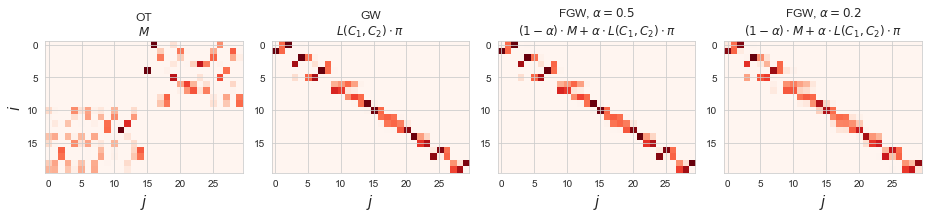

In [32]:
fs = 15
plt.figure(2, (13, 5))
plt.clf()
plt.subplot(1, 4, 1)
plt.imshow(regot.matrix, cmap=cmap, interpolation='nearest')
# plt.imshow(Got, cmap=cmap, interpolation='nearest')
#plt.xlabel("$y$",fontsize=fs)
plt.ylabel("$i$", fontsize=fs)
plt.xlabel("$j$", fontsize=fs)
# plt.xticks(())

plt.title('OT'+ '\n'+ r'$M$')

plt.subplot(1, 4, 2)
plt.imshow(gw.matrix, cmap=cmap, interpolation='nearest')
plt.title('GW'+ '\n'+ r'$ L(C_1,C_2)\cdot \pi $')
# plt.xticks(())
plt.xlabel("$j$", fontsize=fs)

plt.subplot(1, 4, 3)
plt.imshow(fgwot_bal.matrix, cmap=cmap, interpolation='nearest')
plt.title('FGW, '+ r'$\alpha = 0.5$'+ '\n'+ r'$(1-\alpha) \cdot M + \alpha \cdot L(C_1,C_2)\cdot \pi $')

plt.xlabel("$j$", fontsize=fs)

# plt.xticks(())
plt.subplot(1, 4, 4)
plt.imshow(fgwot_unbal.matrix, cmap=cmap, interpolation='nearest')
plt.title('FGW, '+ r'$\alpha = 0.2$'+ '\n'+ r'$(1-\alpha) \cdot M + \alpha \cdot L(C_1,C_2)\cdot \pi $')

plt.xlabel("$j$", fontsize=fs)

plt.tight_layout()
plt.show()